In [3]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import numpy.random as rand
import pickle
import NSMap as ns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.stattools import adfuller

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate Series from a Linear Model

In [4]:
# generate a sinusoidal time series with mean 0, standard deviation 1,
# and 10% observation noise
def generateLinearSeries(length=200, obs_noise=0.1, theta=lambda t: np.pi/6):
    init = rand.random(1) * 2 * np.pi
    
    t = np.linspace(0, 1, num = length)
    ts = np.sin(t * length * theta(t) + init) * np.sqrt(2)
    ts = ts + rand.normal(0, obs_noise, length)

    return ts

# Round 1 of Simulations
Here we assess if NS-Map can distinguish between stationary/nonstationary and linearity/nonlinear dynamics for a set of simulated systems. We also compare the performance of NS-Map to a version where all nonlinearity is suppressed to compare nonstationarity identification skill.

We have included the outputs of previous runs of the simulations in the results directory, and the figures in the paper may be produced by running the code blocks in the figure generation sections later in the notebook. If you wish to rerun the simulations, then execute the 5 code blocks below (this takes a while).

In [13]:
# General Hyperparameters
T = 200
o_n = 0.1
N_replicates = 1
reduction = 2 ** 8
settlingTime = 200
E_max = 5
tau = 1

In [6]:
# Linear Model NSMap vs DLM

theta_list = (lambda t: np.pi / 6, lambda t: (0.5 + t) * np.pi / 6)

results = np.zeros((N_replicates * len(theta_list), 6))
results_index = 0

for ti, theta in enumerate(theta_list):
    for i in range(N_replicates):
        Xr = generateLinearSeries(length=T, obs_noise=o_n, theta=theta)
        
        delta_agg, theta_agg, r_sqrd = ns.get_delta_agg(Xr, E_max, return_forecast_skill=True)
        delta_agg_DLM, theta_agg_DLM, r_sqrd_DLM = ns.get_delta_agg(Xr, E_max, return_forecast_skill=True, theta_fixed=True)
        
        results[results_index] = np.array([ti, delta_agg, theta_agg, r_sqrd, delta_agg_DLM, r_sqrd_DLM])
        results_index += 1

np.savetxt(f"../results/round1_results/linear_NSMap_vs_DLM.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")

In [15]:
# Logistic Map NSMap vs DLM
r_list = (lambda t: 3.75, lambda t: 3.75 - 0.75 * t / T)

results = np.zeros((N_replicates * len(r_list), 6))
results_index = 0

for ri, r in enumerate(r_list):
    for i in range(N_replicates):
        x0 = rand.rand(1)
        Xr = ns.standardize(ns.generateTimeSeriesDiscrete("LogisticP", x0, tlen=T, nsargs=(r,), settlingTime=settlingTime))
        Xr += (rand.normal(0,1,T) * o_n)[:,None]
        
        delta_agg, theta_agg, r_sqrd = ns.get_delta_agg(Xr, E_max, return_forecast_skill=True)
        delta_agg_DLM, theta_agg_DLM, r_sqrd_DLM = ns.get_delta_agg(Xr, E_max, return_forecast_skill=True, theta_fixed=True)
        
        results[results_index] = np.array([ri, delta_agg, theta_agg, r_sqrd, delta_agg_DLM, r_sqrd_DLM])
        results_index += 1
            
np.savetxt(f"../results/round1_results/logistic_NSMap_vs_DLM.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")

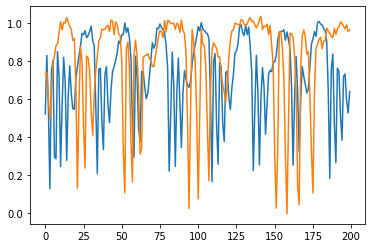

In [17]:
# Food Chain NSMap vs DLM

b1_list = (lambda t: 3, lambda t: 3 + 4 * t / end)

end = T * 5
x0 = np.array([0.1,0.4,9]) + rand.random(3)
# log_std is calculated as the standard deviation on a stationary hastings powell map series with T=200 and b1=3
log_std = np.mean(np.array([np.std(ns.generateTimeSeriesContinuous('FoodChainP', x0, end=end,
                                          tlen = T, nsargs=(b1_list[0],), 
                                          reduction = reduction, settlingTime=settlingTime, 
                                          process_noise=0)[:,0,None]) for i in range(20)]))

# nonstationarity status, delta, theta, r_sqrd, delta_DLM, r_sqrd_DLM
results = np.zeros((N_replicates * len(b1_list), 6))
results_index = 0

for b1i, b1 in enumerate(b1_list):
    for i in range(N_replicates):
        x0 = np.array([0.1,0.4,9]) + rand.random(3)
        Xr = ns.generateTimeSeriesContinuous('FoodChainP', x0, end=end, tlen = T, nsargs=(b1,), 
                                          reduction = reduction, settlingTime=settlingTime, 
                                          process_noise=0)[:,0,None]
        Xr += (rand.normal(0,1,T) * log_std * o_n)[:,None]
        
        delta_agg, theta_agg, r_sqrd = ns.get_delta_agg(Xr, E_max, return_forecast_skill=True)
        delta_agg_DLM, theta_agg_DLM, r_sqrd_DLM = ns.get_delta_agg(Xr, E_max, return_forecast_skill=True, theta_fixed=True)
        
        results[results_index] = np.array([b1i, delta_agg, theta_agg, r_sqrd, delta_agg_DLM, r_sqrd_DLM])
        results_index += 1

np.savetxt(f"../results/round1_results/food_chain_NSMap_vs_DLM.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")

In [154]:
print(f"True Stationary Rate = {np.mean(results[results[:,0] == 0, 1] > 0.05)}")
print(f"True Nonstationary Rate = {np.mean(results[results[:,0] == 2, 1] <= 0.05)}")

True Stationary Rate = 0.0
True Nonstationary Rate = 1.0


# NSMap Demonstration (Figure 1)
Code for generating Figure 1. To regenerate the underlying data, run the following 3 blocks. To just recreate the figure with pre-generated data, run the subsequent two.

In [47]:
# this method is a copy of some code from the NSMap package, which allows internal 
# variables to be plotted explicitly in Figure 1.
def compute_delta(Xr, E, t=None, tau=1, trainingSteps=100, return_forecast_skill=False, theta_fixed=False, make_plots=False, ax=None):
    
    if t is None:
        t = np.linspace(0,1, num=len(Xr))
    else:
        # Remember to standardize t to be between 0 and 1!
        assert t[0] == 0 and t[-1] == 1

    table = np.zeros((E+1, 5))
    hp = np.zeros(2)

    # produce delay embedding vector first so the set of targets is fixed across all E
    Xemb, Y, tx = ns.delayEmbed(Xr, E, tau, t=t)

    # for each number of lags from 0 to E
    for l in range(E+1):
        X = Xemb[:,:l+1]

        thetaNS, deltaNS, lnLNS = ns.optimizeG(X, Y, tx, fixed=np.array([theta_fixed, False]), trainingSteps=trainingSteps, hp=hp.copy())
        thetaS, _, lnLS = ns.optimizeG(X, Y, tx, fixed=np.array([theta_fixed, True]),trainingSteps=trainingSteps, hp=hp.copy())

        table[l] = np.array([deltaNS, lnLNS, lnLS, thetaNS, thetaS])

    lnLdifference = table[:,1] - table[:,2]
    delta_agg_weights = np.exp(lnLdifference - np.max(lnLdifference))
    delta_agg = np.average(table[:,0], weights=delta_agg_weights)
    theta = table[np.argsort(table[:,1])[-1],3]
        
    return Xr, t, table, delta_agg, theta

In [31]:
## Generate new time series

E_max = 9
settlingTime = 200

statlin = generateLinearSeries(length = T, obs_noise = o_n, theta = lambda t: np.pi / 6)
nonstatlin = generateLinearSeries(length = T, obs_noise = o_n, theta = lambda t: (0.5 + t) * np.pi / 6) # lambda t: (0.875 + (t/4)) * np.pi / 6)

x0 = rand.rand(1)
statlog = ns.standardize(ns.generateTimeSeriesDiscrete("LogisticP", x0, tlen=T, nsargs=(lambda t: 3.75,), settlingTime=settlingTime))
statlog += (rand.normal(0,1,T) * o_n)[:,None]

nonstatlog = ns.standardize(ns.generateTimeSeriesDiscrete("LogisticP", x0, tlen=T, nsargs=(lambda t: 3.75 - 0.75 * t / T,), settlingTime=settlingTime))
nonstatlog += (rand.normal(0,1,T) * o_n)[:,None]

In [32]:
# assess nonstationarity of the generated time series
stuff_dict = {}
for i, series in enumerate((statlin, nonstatlin, statlog, nonstatlog)):
    stuff_dict[i] = compute_delta(series, E_max)
    delta, theta, r_sqrd = ns.get_delta_agg(series, E_max, return_forecast_skill=True)
    print(f"delta = {delta}, theta = {theta}, r^2 = {r_sqrd}")

# save the data for the figure
with open('../results/NSMap_demonstration.pkl', 'wb') as fp:
    pickle.dump(stuff_dict, fp)

delta = 0.0, theta = 0.0, r^2 = 0.989371160807645
delta = 65.85200585001152, theta = 0.0, r^2 = 0.9743762546793935
delta = 0.0, theta = 5.249279999999999, r^2 = 0.9717397429825728
delta = 16.20425478144029, theta = 3.0447071016959995, r^2 = 0.9689989117699522


In [48]:
# load the data for the figure
with open('../results/NSMap_demonstration.pkl', 'rb') as fp:
    stuff_dict = pickle.load(fp)

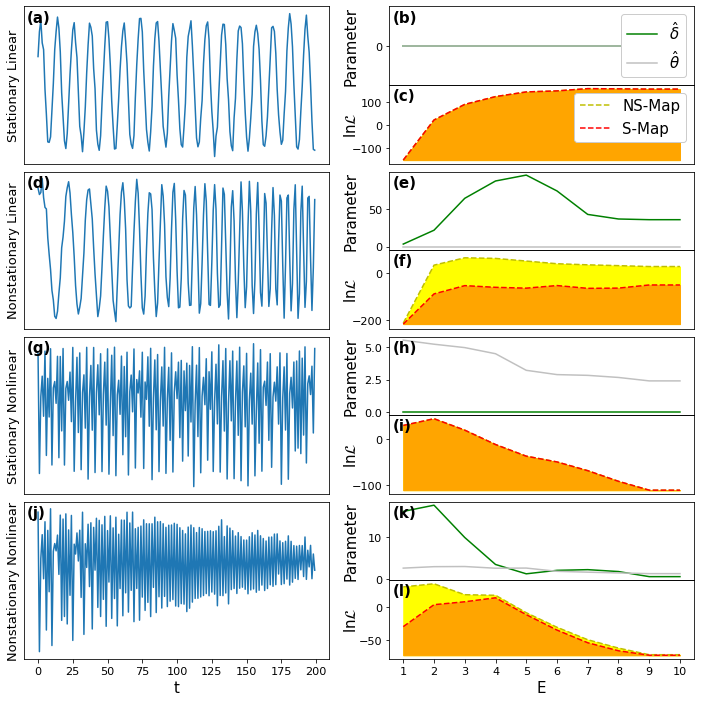

In [57]:
vfig, vax = plt.subplots(4, 2, figsize=(12,12))
maxLags = 9
fsize = 15
text_padding = 0.01
label_pad = -0.15

names = ["Stationary Linear", "Nonstationary Linear", "Stationary Nonlinear", "Nonstationary Nonlinear"]
labelnames = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']

# for series, ax in zip((statlin, nonstatlin, statlog, nonstatlog), vax.flatten()):
for ax_row, i in zip(vax, np.arange(4)):
    E_range = range(1,maxLags+2)
    
    series, t, table, delta_agg, theta = stuff_dict[i]

    ax_row[0].plot(series)
    ax_row[0].set_yticks([])
    ax_row[0].set_ylabel(names[i], size=fsize-2)
    ax_row[0].tick_params(axis='both', which='major', labelsize=fsize * 3 / 4)
    if i == 3:
        ax_row[0].set_xlabel(r"t", size=fsize)
    else:
        ax_row[0].set_xticks([])
    
    minLine = (table[:,2] * 0)+min(min(table[:,2]),min(table[:,1])) 

    ax_row[1].plot(E_range, table[:,1], "y--", label=r"NS-Map")
    ax_row[1].fill_between(E_range, table[:,1], minLine, color = "yellow")
    ax_row[1].plot(E_range, table[:,2], "r--", label=r"S-Map")
    ax_row[1].fill_between(E_range, table[:,2], minLine, color="orange")
    ax_row[1].set_xticks(E_range)
    if i != 3:
        ax_row[1].set_xticks([])
    else:
        ax_row[1].set_xlabel("E", size = fsize)
    if i == 1:
        ax_row[1].set_ylim([minLine[0]-20, 100])
    ax_row[1].tick_params(axis='both', which='major', labelsize=fsize * 3 / 4)
    
    divider = make_axes_locatable(ax_row[1])
    bax = divider.append_axes('top', size='100%', pad=0)
    
    bax.plot(E_range, table[:,0], label=r"$\hat{\delta}$", color="green")
    bax.plot(E_range, table[:,3], label=r"$\hat{\theta}$", color="silver")
    bax.set_xticks([])
    bax.tick_params(axis='both', which='major', labelsize=fsize * 3 / 4)
    
    ax_row[0].text(text_padding, 1-text_padding*2, f"{labelnames[3*i]}", size=fsize, fontweight="bold",
           horizontalalignment="left", verticalalignment="top",
           transform=ax_row[0].transAxes)
    bax.text(text_padding, 1-text_padding*4, f"{labelnames[3*i+1]}", size=fsize,fontweight="bold",
           horizontalalignment="left",verticalalignment="top",
           transform=bax.transAxes)
    bax.text(label_pad, 0.5, r"Parameter", size=fsize,
           horizontalalignment="left", verticalalignment="center", rotation = 90,
           transform=bax.transAxes)
    ax_row[1].text(text_padding, 1-text_padding*4, f"{labelnames[3*i+2]}", size=fsize, fontweight="bold",
           horizontalalignment="left",verticalalignment="top",
           transform=ax_row[1].transAxes)
    ax_row[1].text(label_pad, 0.5, r"$\ln\mathcal{L}$", size=fsize, rotation = 90, 
           horizontalalignment="left",verticalalignment="center",
           transform=ax_row[1].transAxes)
    
    if i == 0:
        bax.legend(fontsize = fsize, framealpha=1)
        bax.set_yticks([0])
        ax_row[1].legend(fontsize = fsize, framealpha=1)
        
plt.subplots_adjust(wspace=0.2,
                    hspace=0.05)
plt.savefig(f"../figures_eps/Figure_1.eps", format="eps", bbox_inches="tight", transparent=False)

# Delta vs Theta (Figure 2)

In [36]:
# fill with data of results for Hastings Powell and Logistic in Round 2
# l_data = np.loadtxt("simulation_results_final\logistic_NSMap_vs_DLM.csv",delimiter=',')
# fc_data = np.loadtxt("simulation_results_final\hastings_powell_NSMap_vs_DLM.csv",delimiter=',')
# lin_data = np.loadtxt("simulation_results_final\linear_NSMap_vs_DLM.csv",delimiter=',')
lin_data = np.loadtxt("../results/round1_results/linear_NSMap_vs_DLM.csv",delimiter=',')
l_data = np.loadtxt("../results/round1_results/logistic_NSMap_vs_DLM.csv",delimiter=',')
fc_data = np.loadtxt("../results/round1_results/food_chain_NSMap_vs_DLM.csv",delimiter=',')

l_nonstat = np.log(l_data[l_data[:,0] == 1][:,1:3]+1)
l_stat = np.log(l_data[l_data[:,0] == 0][:,1:3]+1)
fc_nonstat = np.log(fc_data[fc_data[:,0] == 1][:,1:3]+1)
fc_stat = np.log(fc_data[fc_data[:,0] == 0][:,1:3]+1)
lin_nonstat = np.log(lin_data[lin_data[:,0] == 1][:,1:3]+1)
lin_stat = np.log(lin_data[lin_data[:,0] == 0][:,1:3]+1)

In [37]:
np.sum(np.all(lin_stat == np.zeros(2), axis=1))

77

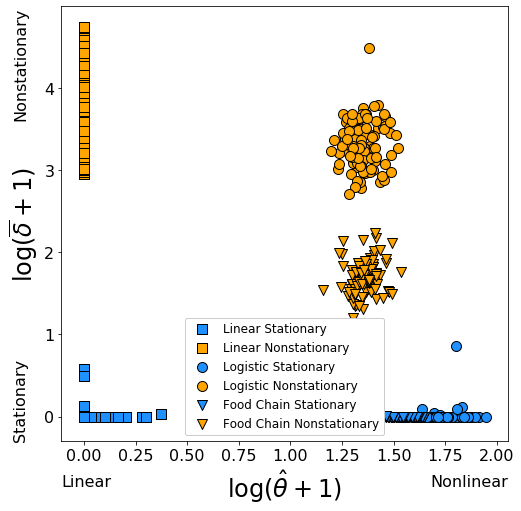

In [59]:
size = 100
alpha = 1
dither = 0.02
fontsize_ticks = 16
fontsize_legend = 12
fontsize_axis = 24
fontsize_text = 16
text_padding = -0.075

dithering = lambda: rand.normal(0,dither,size=size)

dvt_fig, dvt_ax = plt.subplots(1, figsize=(8,8))
dvt_ax.set_xlabel(r"$\log(\hat{\theta}+1)$",fontsize=fontsize_axis)
dvt_ax.set_ylabel(r"$\log(\overline{\delta}+1)$",fontsize=fontsize_axis)
# dvt_ax.set_xticks([0,1.75])
dvt_ax.text(text_padding, 1, "Nonstationary", size=fontsize_text, rotation=90, 
            horizontalalignment="right", verticalalignment="top",
            transform=dvt_ax.transAxes)
dvt_ax.text(text_padding, 0, "Stationary", size=fontsize_text, rotation=90,
           horizontalalignment="right",verticalalignment="bottom",
           transform=dvt_ax.transAxes)
dvt_ax.text(0, text_padding, "Linear", size=fontsize_text,
           horizontalalignment="left",verticalalignment="top",
           transform=dvt_ax.transAxes)
dvt_ax.text(1, text_padding, "Nonlinear", size=fontsize_text,
           horizontalalignment="right",verticalalignment="top",
           transform=dvt_ax.transAxes)

dvt_ax.scatter(lin_stat[:,1], lin_stat[:,0], 
               c="dodgerblue",marker="s", s=size, edgecolors="black", 
               label="Linear Stationary", alpha=alpha)
dvt_ax.scatter(lin_nonstat[:,1], lin_nonstat[:,0], 
               c="orange",marker="s", s=size, edgecolors="black", 
               label="Linear Nonstationary", alpha=alpha)
dvt_ax.scatter(l_stat[:,1], l_stat[:,0], 
               c="dodgerblue", s=size, edgecolors="black", 
               label="Logistic Stationary", alpha=alpha)
dvt_ax.scatter(l_nonstat[:,1], l_nonstat[:,0], 
               c="orange", s=size, edgecolors="black", 
               label="Logistic Nonstationary", alpha=alpha)
dvt_ax.scatter(fc_stat[:,1], fc_stat[:,0], 
               c="dodgerblue",marker="v", s=size, edgecolors="black", 
               label="Food Chain Stationary", alpha=alpha)
dvt_ax.scatter(fc_nonstat[:,1], fc_nonstat[:,0], 
               c="orange",marker="v", s=size, edgecolors="black", 
               label="Food Chain Nonstationary", alpha=alpha)

plt.xticks(fontsize=fontsize_ticks, rotation=0)
plt.yticks(fontsize=fontsize_ticks, rotation=0)
plt.legend(prop={"size":fontsize_legend}, framealpha=1)
plt.savefig(f"../figures_eps/round1_results/Figure_2.eps", format="eps", bbox_inches="tight", transparent=False)

## NSMap vs DLM (Figure 3)

In [40]:
lin_data = np.loadtxt("../results/round1_results/linear_NSMap_vs_DLM.csv",delimiter=',')
l_data = np.loadtxt("../results/round1_results/logistic_NSMap_vs_DLM.csv",delimiter=',')
fc_data = np.loadtxt("../results/round1_results/food_chain_NSMap_vs_DLM.csv",delimiter=',')

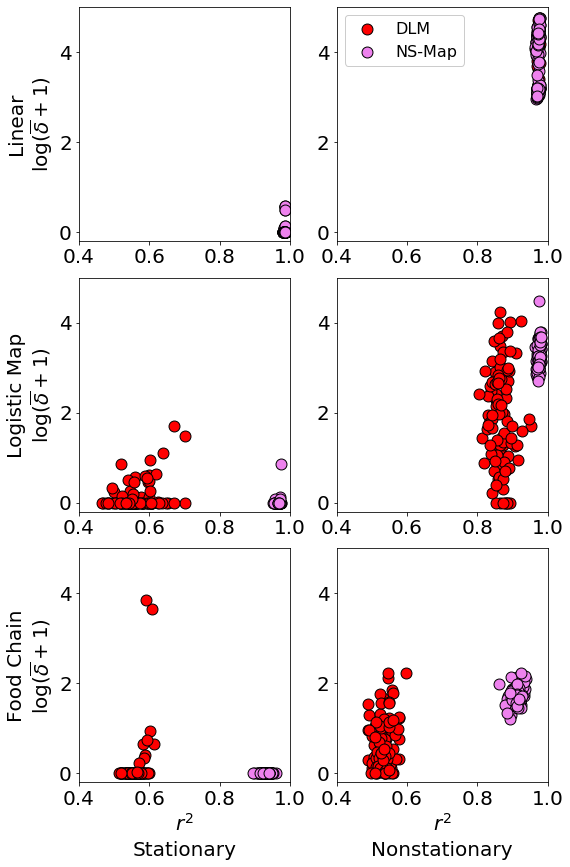

In [60]:
vfig, vax = plt.subplots(3,2,figsize=(8,12))
B=40
size = 120
fontsize_axis = 20
fontsize_ticks = 20
fontsize_text = 20

text_padding_y = -0.25
text_padding_x = -0.25

dithering = lambda : rand.normal(0,0.05,100)

for m, model in enumerate(["lin", "l", "fc"]):
    data = locals()[model + "_" + "data"]
    for s, status in enumerate(["none", "fast"]):
        datap = data[data[:,0] == s]
        vax[m,min(1,s)].scatter(datap[:,5], np.log(datap[:,4]+1),
                         color="red",s=size, 
                         edgecolors="black",
                         alpha=1,label="DLM")
        vax[m,min(1,s)].scatter(datap[:,3], np.log(datap[:,1]+1),
                         color="violet",s=size, 
                         edgecolors="black",
                         alpha=1,label="NS-Map")

        vax[m,min(1,s)].set_xlim([0.4,1])
        vax[m,min(1,s)].set_ylim([-0.2,5])
        vax[m,min(1,s)].tick_params(axis='both',which='major',
                             labelsize=fontsize_ticks)

for i in range(3):
    vax[i,0].set_ylabel(r"$\log(\overline{\delta}+1)$",size=fontsize_axis)
for i in range(2):
    vax[2,i].set_xlabel(r"$r^2$",size=fontsize_axis)


vax[0,0].text(text_padding_y, 0.5, "Linear", rotation=90,
              verticalalignment="center", horizontalalignment="right",
              transform=vax[0,0].transAxes,size=fontsize_text)
vax[1,0].text(text_padding_y, 0.5, "Logistic Map", rotation=90,
              verticalalignment="center", horizontalalignment="right",
              transform=vax[1,0].transAxes,size=fontsize_text)
vax[2,0].text(text_padding_y, 0.5, "Food Chain", rotation=90,
              verticalalignment="center", horizontalalignment="right",
              transform=vax[2,0].transAxes,size=fontsize_text)
vax[2,0].text(0.5, text_padding_x, "Stationary",
              verticalalignment="top", horizontalalignment="center",
              transform=vax[2,0].transAxes,size=fontsize_text)
vax[2,1].text(0.5, text_padding_x, "Nonstationary", 
              verticalalignment="top", horizontalalignment="center",
              transform=vax[2,1].transAxes,size=fontsize_text)
# vax[2,2].text(0.5, text_padding_x, "Fast Nonstationary", 
#               verticalalignment="top", horizontalalignment="center",
#               transform=vax[2,2].transAxes,size=fontsize_text)

vax[0,1].legend(fontsize=16, framealpha=1)
plt.tight_layout()
# plt.savefig("../Figures/round1_NSMap_vs_DLM.png", dpi=300)
plt.savefig("../figures_eps/round1_results/Figure_3.eps", format="eps", bbox_inches="tight", transparent = False)

In [42]:
# Compute the increase in forecast skill for nonlinear models from SMap to NSMap,
# averaging over all nonstationary categories

print(f"Logistic NSMap r_sqrd = {np.mean(l_data[:,3])}")
print(f"Logistic SMap r_sqrd = {np.mean(l_data[:,5])}")
print(f"Food Chain NSMap r_sqrd = {np.mean(fc_data[:,3])}")
print(f"Food Chain SMap r_sqrd = {np.mean(fc_data[:,5])}")

Logistic NSMap r_sqrd = 0.9705834999999999
Logistic SMap r_sqrd = 0.7155315
Food Chain NSMap r_sqrd = 0.9205930000000001
Food Chain SMap r_sqrd = 0.5459945


# Round 1 Example Time Series (Figure S2)

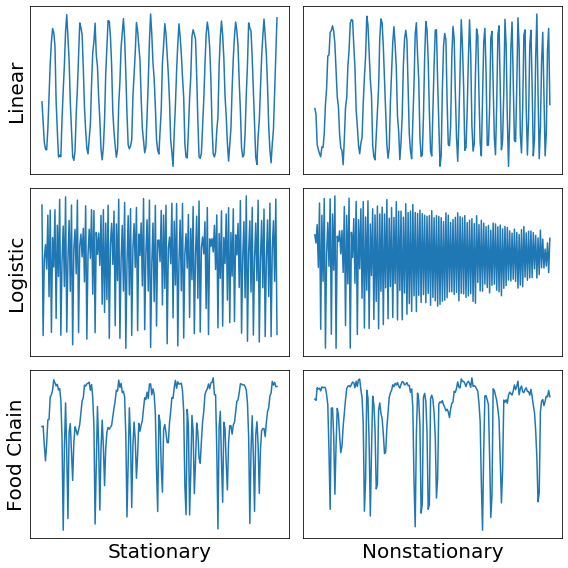

In [43]:
fig, ax = plt.subplots(3,2,figsize=(8,8), tight_layout=True)

# Linear Model NSMap vs DLM
E_max = 2

# ts_std is the standard deviation of the time series which
# is normalized to 1
log_std = 1
# theta_list = (lambda t: np.pi / 6, lambda t: (0.875 + (t/4)) * np.pi / 6, lambda t: (0.5 + t) * np.pi / 6)
theta_list = (lambda t: np.pi / 6, lambda t: (0.5 + t) * np.pi / 6)

for ti, theta in enumerate(theta_list):
    Xr = generateLinearSeries(length=T, obs_noise=o_n, theta=theta)
    Xr += (rand.normal(0,1,T) * log_std * o_n)
        
    ax[0, ti].plot(np.linspace(0,1,num=T), Xr)
    ax[0, ti].set_xticks([])
    ax[0, ti].set_yticks([])
        
# r_list = (lambda t: 3.75, lambda t: 3.75 - 0.25 * t / T, lambda t: 3.75 - 0.75 * t / T)
r_list = (lambda t: 3.75, lambda t: 3.75 - 0.75 * t / T)
settlingTime = 200

for ri, r in enumerate(r_list):
    x0 = rand.rand(1)
    Xr = ns.standardize(ns.generateTimeSeriesDiscrete("LogisticP", x0, tlen=T, nsargs=(r,), settlingTime=settlingTime))
    Xr += (rand.normal(0,1,T) * o_n)[:,None]
        
    ax[1, ri].plot(np.linspace(0,1,num=T), Xr)
    ax[1, ri].set_xticks([])
    ax[1, ri].set_yticks([])

end = T * 5
E_max = 4
settlingTime = 2 ** 9
# b1_list = (lambda t: 3, lambda t: 3 + 2 * t / end, lambda t: 3 + 4 * t / end)
b1_list = (lambda t: 3, lambda t: 3 + 4 * t / end)

x0 = np.array([0.1,0.4,9]) + rand.random(3)
# log_std is calculated as the standard deviation on a stationary hastings powell map series with T=200 and b1=3
log_std = np.mean(np.array([np.std(ns.generateTimeSeriesContinuous('FoodChainP', x0, end=end,
                                          tlen = T, nsargs=(b1_list[0],), 
                                          reduction = reduction, settlingTime=settlingTime, 
                                          process_noise=0)[:,0,None]) for i in range(20)]))

for b1i, b1 in enumerate(b1_list):
    x0 = np.array([0.1,0.4,9]) + rand.random(3)
    Xr = ns.generateTimeSeriesContinuous('FoodChainP', x0, end=end, tlen = T, nsargs=(b1,), 
                                      reduction = reduction, settlingTime=settlingTime, 
                                      process_noise=0)[:,0,None]
    Xr += (rand.normal(0,1,T) * log_std * o_n)[:,None]

    ax[2, b1i].plot(np.linspace(0,1,num=T), Xr)
    ax[2, b1i].set_xticks([])
    ax[2, b1i].set_yticks([])
    
ns_status = ["Stationary", "Nonstationary"]
    
for i in range(3):
    ax[i,0].set_ylabel(r"{}".format(["Linear", "Logistic", "Food Chain"][i]), rotation=90,
                     fontsize=20)
for i in range(2):
    ax[2,i].set_xlabel(r"{}".format(ns_status[i]), fontsize=20)
plt.savefig("../figures_eps/example_series/Figure_S2.eps", format="eps", bbox_inches="tight")